In [220]:
import pandas as pd
import matplotlib.pyplot as plt


TRADER_NAMES = ['Remy', 'Vinnie', 'Vladimir']

TRADER = 'Vinnie' #Set to one of the names above
PRODUCT = 'CHOCOLATE'

# Read in trade data with names and create one big df
df1 = pd.read_csv('../../../data/round-5-island-data-bottle/trades_round_3_day_0_wn.csv', sep=';')
df2 = pd.read_csv('../../../data/round-5-island-data-bottle/trades_round_3_day_1_wn.csv', sep=';')
df2['timestamp'] = df2['timestamp'] + 1000000
df3 = pd.read_csv('../../../data/round-5-island-data-bottle/trades_round_3_day_2_wn.csv', sep=';')
df3['timestamp'] = df3['timestamp'] + 2000000
df = pd.concat([df1, df2, df3])
df = df.query('symbol==@PRODUCT')
trades_grouped = df.groupby('timestamp').agg({'quantity': 'sum'}).reset_index()

# Read in prices data and create one big df
df1 = pd.read_csv('../../../data/round-3-island-data-bottle/prices_round_3_day_0.csv', sep=';')
df2 = pd.read_csv('../../../data/round-3-island-data-bottle/prices_round_3_day_1.csv', sep=';')
df2['timestamp'] = df2['timestamp'] + 1000000
df3 = pd.read_csv('../../../data/round-3-island-data-bottle/prices_round_3_day_2.csv', sep=';')
df3['timestamp'] = df3['timestamp'] + 2000000
prices = pd.concat([df1, df2, df3])
prices = prices.query('product==@PRODUCT')
prices['spread'] = prices['ask_price_1'] - prices['bid_price_1']
prices['mid_price_change_next'] = prices['mid_price'].shift(-1) - prices['mid_price']
prices['mid_price_change_last'] = prices['mid_price'] - prices['mid_price'].shift(1)
# make the total volume the sum of the volumes but make it nan safe
prices['total_ask_volume'] = prices['ask_volume_1'].fillna(0) + prices['ask_volume_2'].fillna(0) + prices['ask_volume_3'].fillna(0)
prices['total_bid_volume'] = prices['bid_volume_1'].fillna(0) + prices['bid_volume_2'].fillna(0) + prices['bid_volume_3'].fillna(0)
prices = pd.merge(prices, trades_grouped, on='timestamp', how='left')
prices['quantity'] = prices['quantity'].fillna(0)
prices.rename(columns={'quantity': 'total_traded_volume_all'}, inplace=True)
print(f'Buyers of {PRODUCT} and number of trades: {df.buyer.value_counts()}')
print(f'Sellers of {PRODUCT} and number of trades: {df.seller.value_counts()}')

Buyers of CHOCOLATE and number of trades: buyer
Vinnie      1768
Remy        1077
Vladimir       3
Name: count, dtype: int64
Sellers of CHOCOLATE and number of trades: seller
Remy        1188
Vinnie      1071
Vladimir     589
Name: count, dtype: int64


General stats rather than based on a single trader

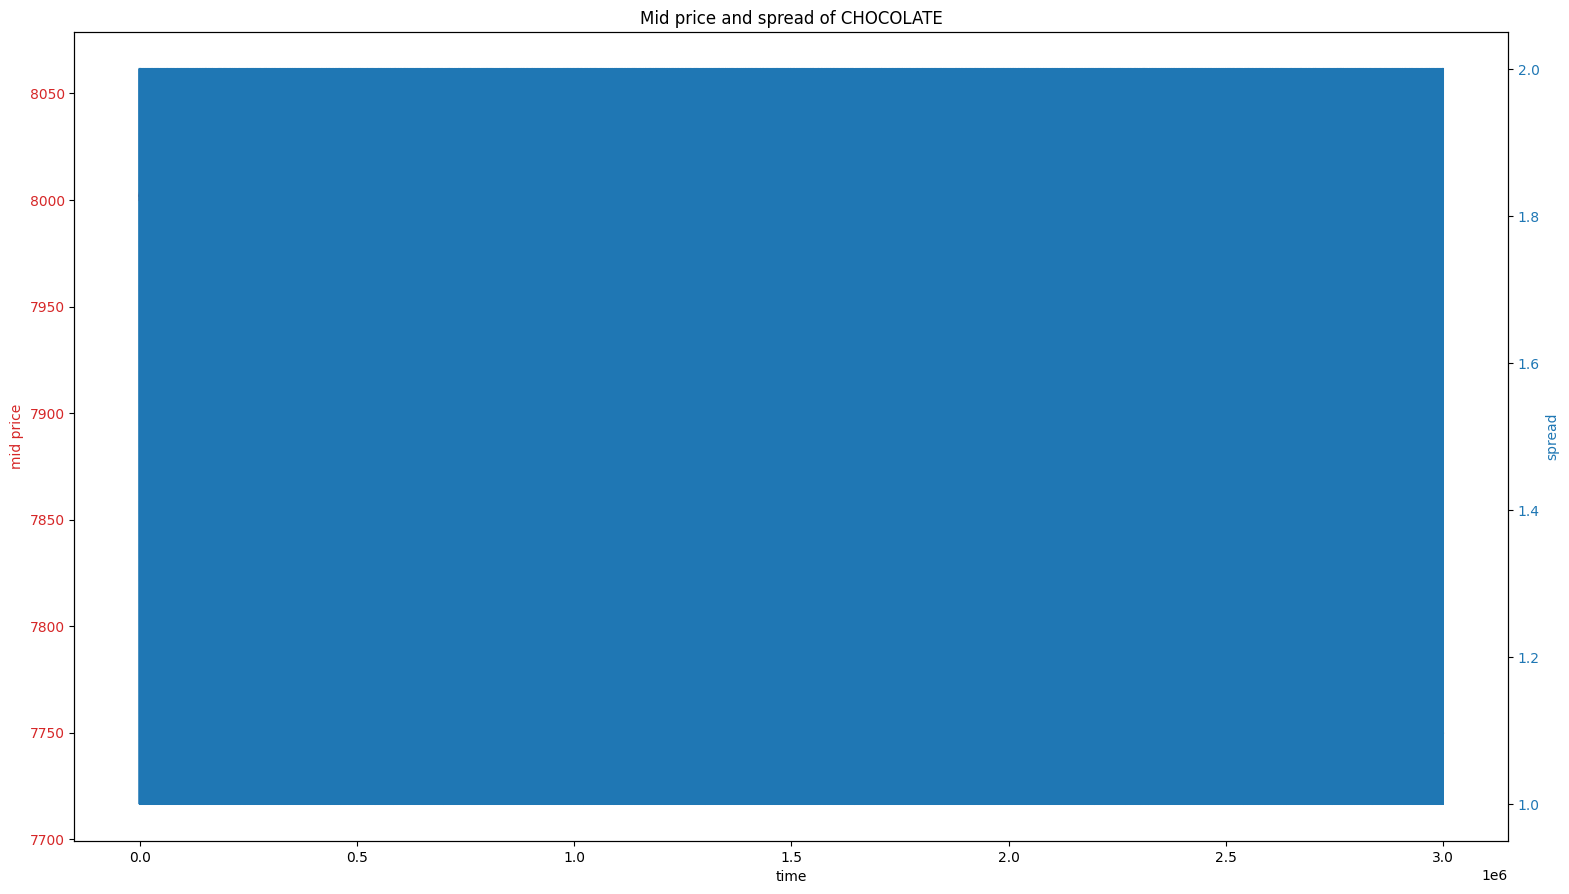

Corelation between mid price change and spread: -0.001359166570954666
Correlaton between mid price change and total ask volume: 0.00036613539607885165
Correlaton between mid price change and total bid volume: -0.0019286822773528505
Correlation between mid price change and mid price change last: -0.016363216375923053


In [221]:
#plot the mid price and the spread on the same graph with different y axis
fig, ax = plt.subplots()

color = 'tab:red'
ax.set_xlabel('time')
ax.set_ylabel('mid price', color=color)
ax.plot(prices['timestamp'], prices['mid_price'], color=color)
ax.tick_params(axis='y', labelcolor=color)

ax2 = ax.twinx()
color = 'tab:blue'
ax2.set_ylabel('spread', color=color)
ax2.plot(prices['timestamp'], prices['spread'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title(f'Mid price and spread of {PRODUCT}')
fig.set_size_inches(18.5, 10.5)
plt.show()

print(f'Corelation between mid price change and spread: {prices["mid_price_change_next"].corr(prices["spread"])}')
print(f'Correlaton between mid price change and total ask volume: {prices["mid_price_change_next"].corr(prices["total_ask_volume"])}')
print(f'Correlaton between mid price change and total bid volume: {prices["mid_price_change_next"].corr(prices["total_bid_volume"])}')
print(f'Correlation between mid price change and mid price change last: {prices["mid_price_change_next"].corr(prices["mid_price_change_last"])}')

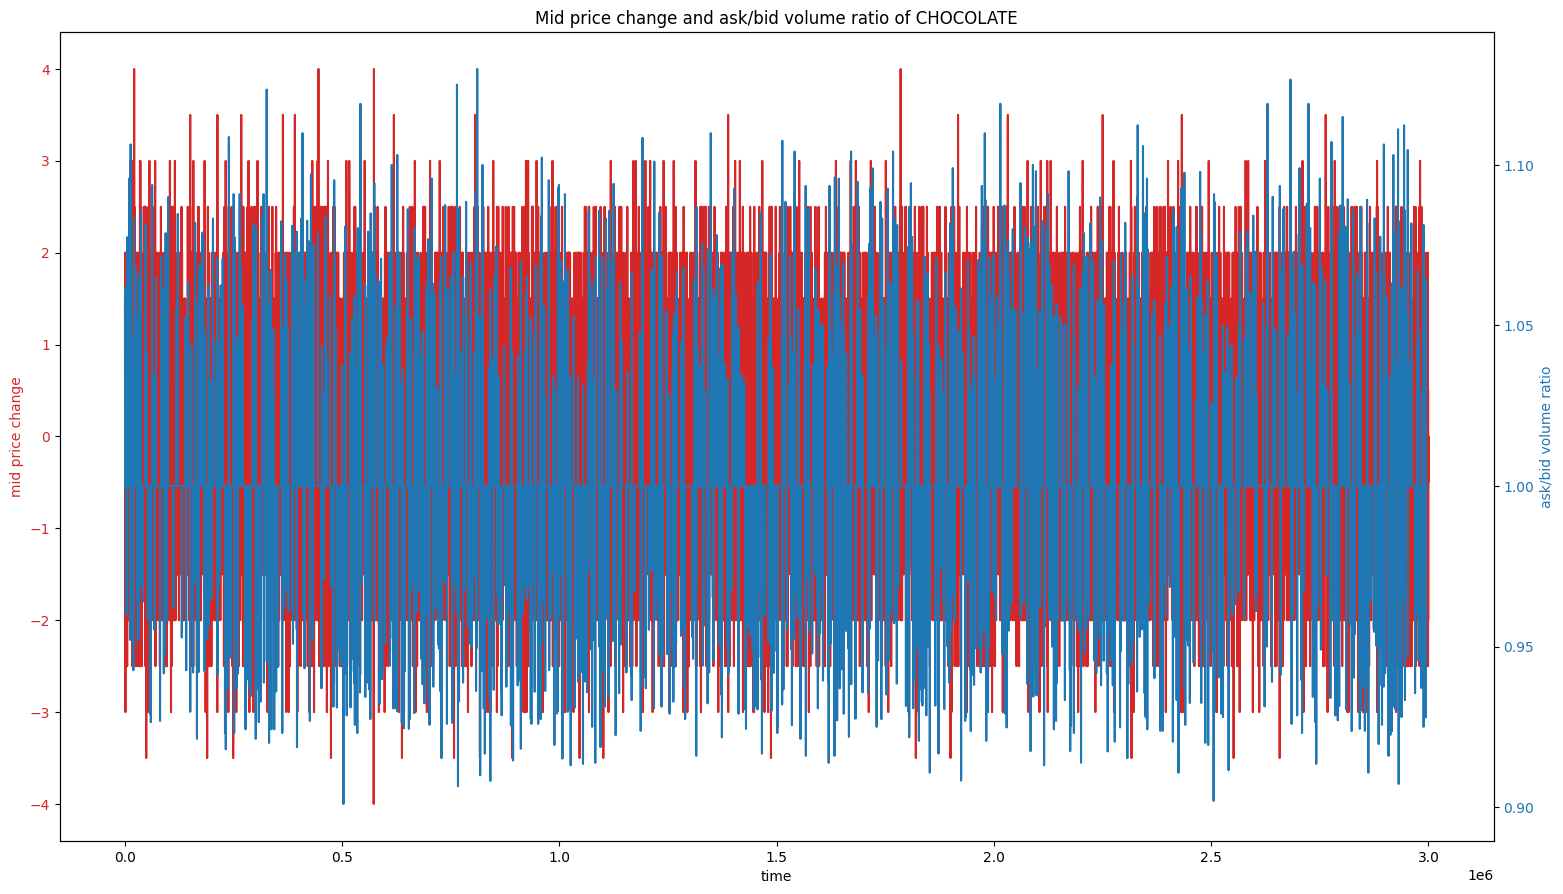

Corelation between mid price change and ask/bid volume ratio: 0.022746795709357566


In [222]:
#plot ratio of total ask volume to total bid volume and mid price change
fig, ax = plt.subplots()

color = 'tab:red'
ax.set_xlabel('time')
ax.set_ylabel('mid price change', color=color)
ax.plot(prices['timestamp'], prices['mid_price_change_next'], color=color)
ax.tick_params(axis='y', labelcolor=color)

ax2 = ax.twinx()
color = 'tab:blue'
ax2.set_ylabel('ask/bid volume ratio', color=color)
ax2.plot(prices['timestamp'], prices['total_ask_volume']/prices['total_bid_volume'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title(f'Mid price change and ask/bid volume ratio of {PRODUCT}')
fig.set_size_inches(18.5, 10.5)
plt.show()

print(f'Corelation between mid price change and ask/bid volume ratio: {prices["mid_price_change_next"].corr(prices["total_ask_volume"]/prices["total_bid_volume"])}')

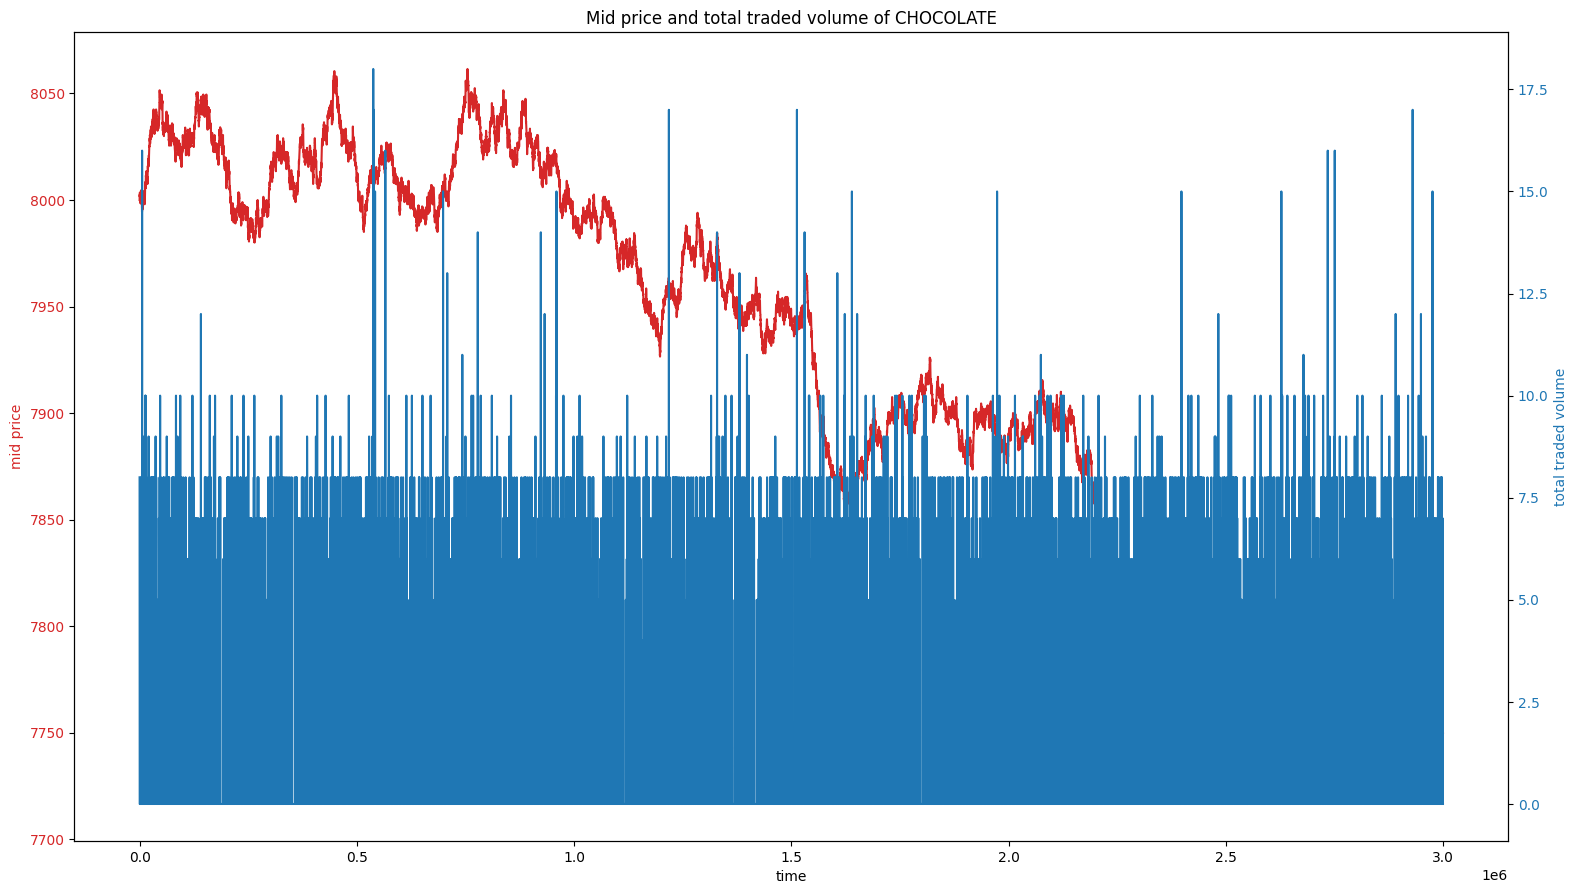

In [223]:
#plot total traded volume and mid price on the same graph with different y axis
fig, ax = plt.subplots()

color = 'tab:red'
ax.set_xlabel('time')
ax.set_ylabel('mid price', color=color)
ax.plot(prices['timestamp'], prices['mid_price'], color=color)
ax.tick_params(axis='y', labelcolor=color)

ax2 = ax.twinx()
color = 'tab:blue'
ax2.set_ylabel('total traded volume', color=color)
ax2.plot(prices['timestamp'], prices['total_traded_volume_all'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title(f'Mid price and total traded volume of {PRODUCT}')
fig.set_size_inches(18.5, 10.5)
plt.show()


For each trader we want to show:

1.) position over time, assuming they start at position 0 and have to cloas at mid price at EOD
2.) plot of when they trade and how much they trade over time plotted against mid price

In [224]:
df_trader = df.query('buyer==@TRADER or seller==@TRADER').copy()
df_trader['quantity'] = df_trader.apply(lambda x: x['quantity'] if x['buyer'] == TRADER else -x['quantity'], axis=1)
df_trader_1 = df_trader.query('timestamp < 1000000').copy()
df_trader_1['position'] = df_trader_1['quantity'].cumsum()
df_trader_2 = df_trader.query('timestamp < 2000000 and timestamp >= 1000000').copy()
df_trader_2['position'] = df_trader_2['quantity'].cumsum()
df_trader_3 = df_trader.query('timestamp < 3000000 and timestamp >= 2000000').copy()
df_trader_3['position'] = df_trader_3['quantity'].cumsum()
df_trader = pd.concat([df_trader_1, df_trader_2, df_trader_3])
df_trader_grouped = df_trader.groupby('timestamp').agg({'quantity': 'sum'}).reset_index()
prices = pd.merge(prices, df_trader_grouped, on='timestamp', how='left')
prices['quantity'] = prices['quantity'].fillna(0)
prices.rename(columns={'quantity': f'total_traded_volume_{TRADER}'}, inplace=True)
df_trader = df_trader.merge(prices[['timestamp', 'mid_price', 'spread', 'total_ask_volume', 'total_bid_volume', 'mid_price_change_next']], on='timestamp', how='right')

#fill na values of position with most recent value
df_trader['position'] = df_trader['position'].fillna(method='ffill')
df_trader['position'] = df_trader['position'].fillna(0)

/var/folders/qz/2xz7hqzj4mv4_58tqxfy0z640000gn/T/ipykernel_84092/500599084.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_trader['position'] = df_trader['position'].fillna(method='ffill')


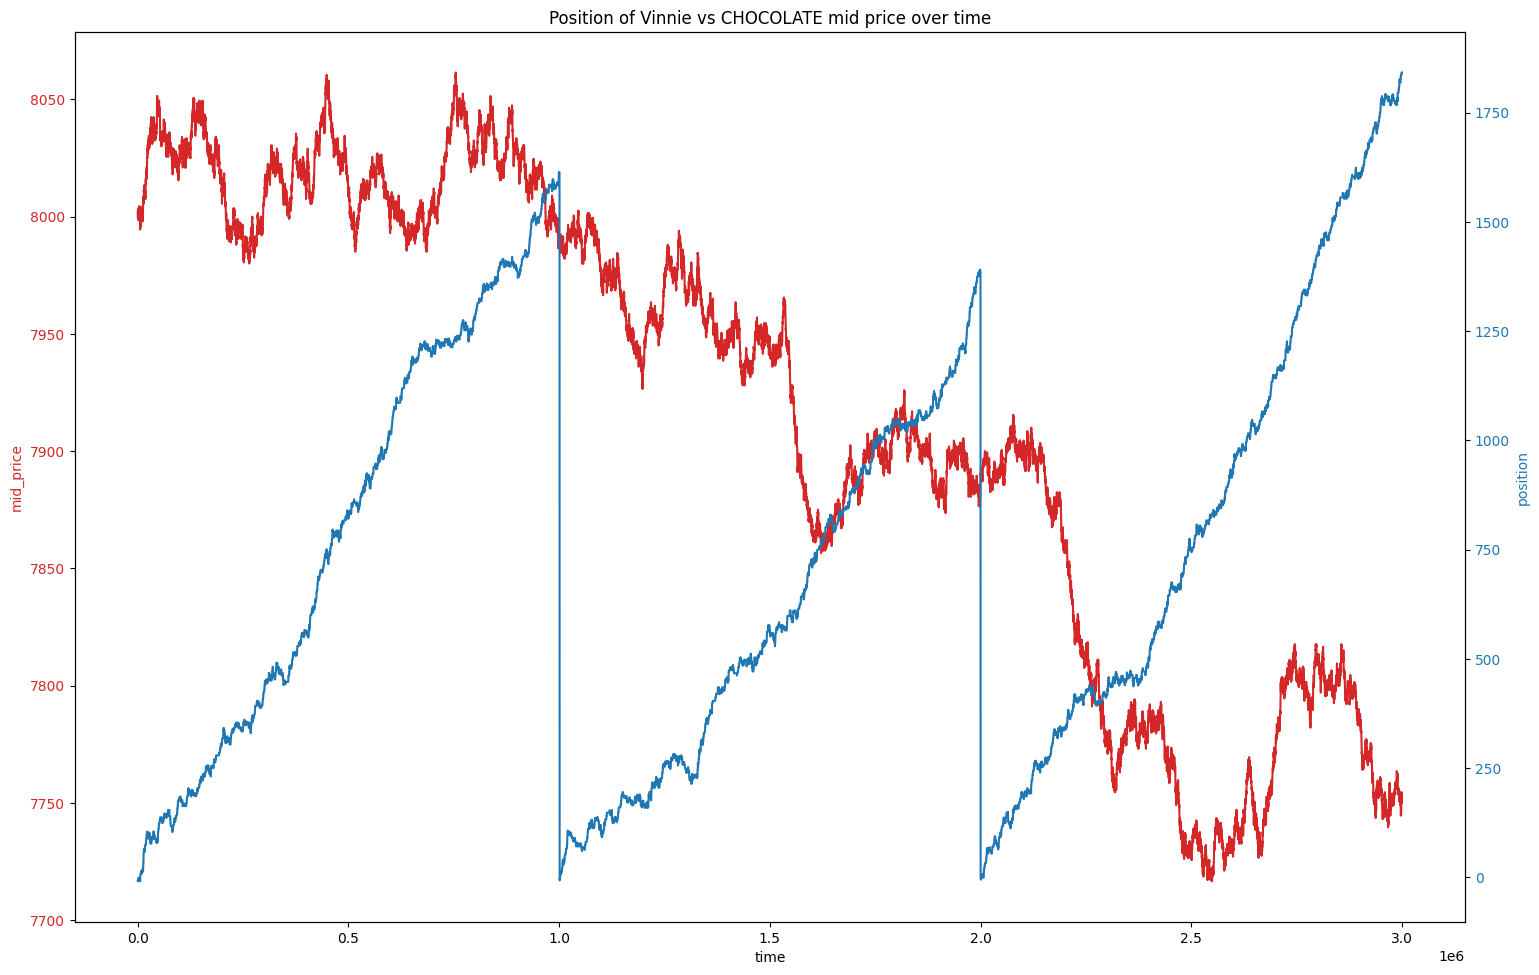

In [225]:
#plot position and price over time wtih right y axis for position
#make figure very wide to see the data better
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('mid_price', color=color)
ax1.plot(df_trader['timestamp'], df_trader['mid_price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('position', color=color)
ax2.plot(df_trader['timestamp'], df_trader['position'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.set_size_inches(18.5, 10.5)
#set title
plt.title(f'Position of {TRADER} vs {PRODUCT} mid price over time')
plt.show()

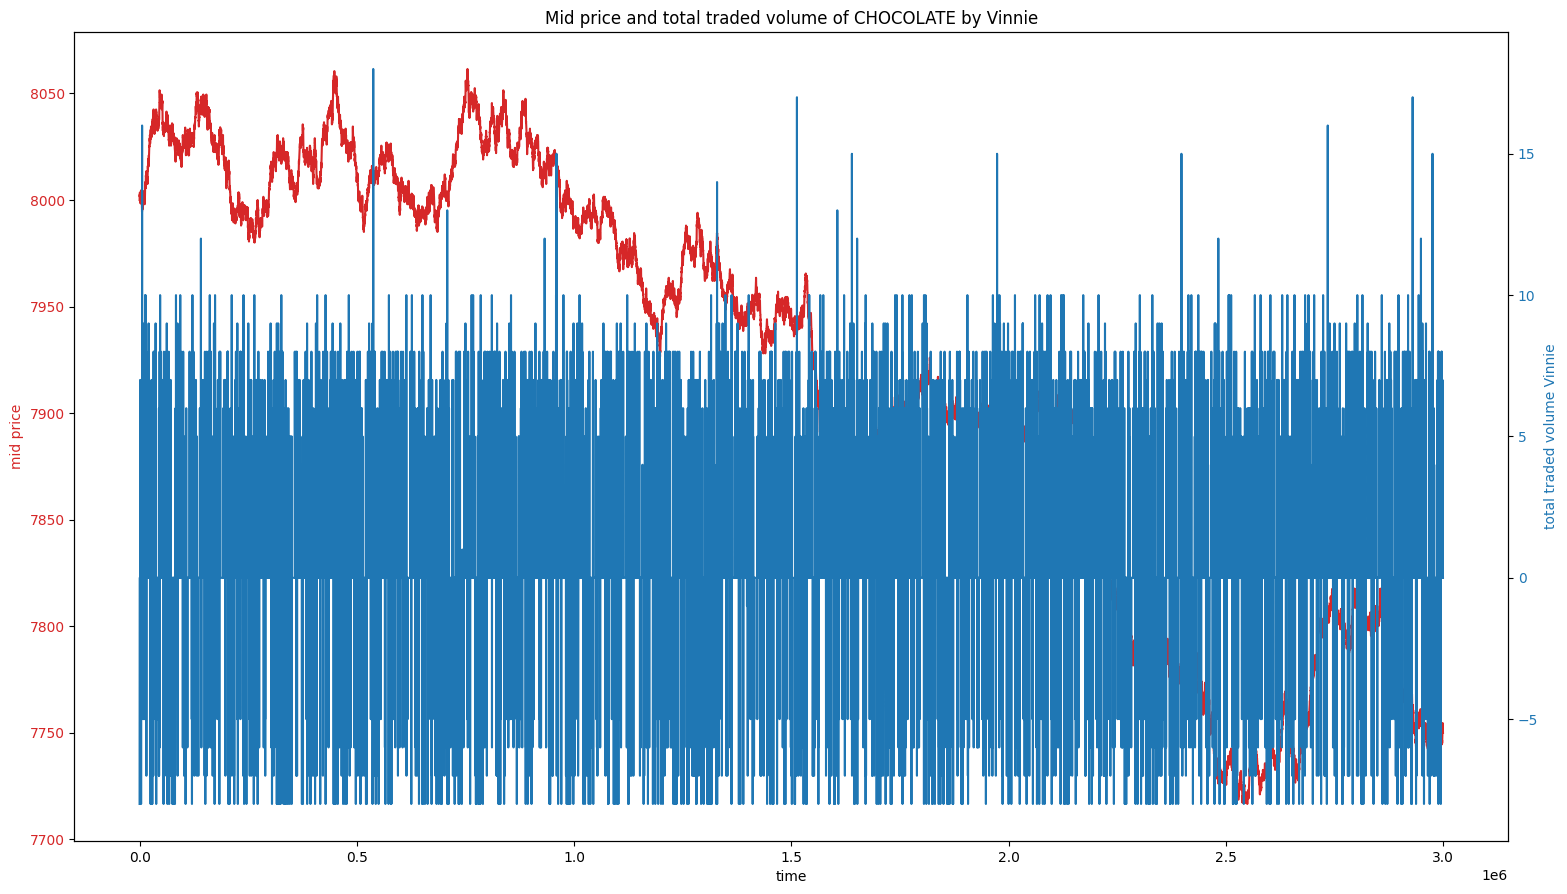

In [226]:
#plot trader's trading volume and mid price on the same graph with different y axis
fig, ax = plt.subplots()

color = 'tab:red'
ax.set_xlabel('time')
ax.set_ylabel('mid price', color=color)
ax.plot(prices['timestamp'], prices['mid_price'], color=color)
ax.tick_params(axis='y', labelcolor=color)

ax2 = ax.twinx()
color = 'tab:blue'
ax2.set_ylabel(f'total traded volume {TRADER}', color=color)
ax2.plot(prices['timestamp'], prices[f'total_traded_volume_{TRADER}'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title(f'Mid price and total traded volume of {PRODUCT} by {TRADER}')
fig.set_size_inches(18.5, 10.5)

plt.show()

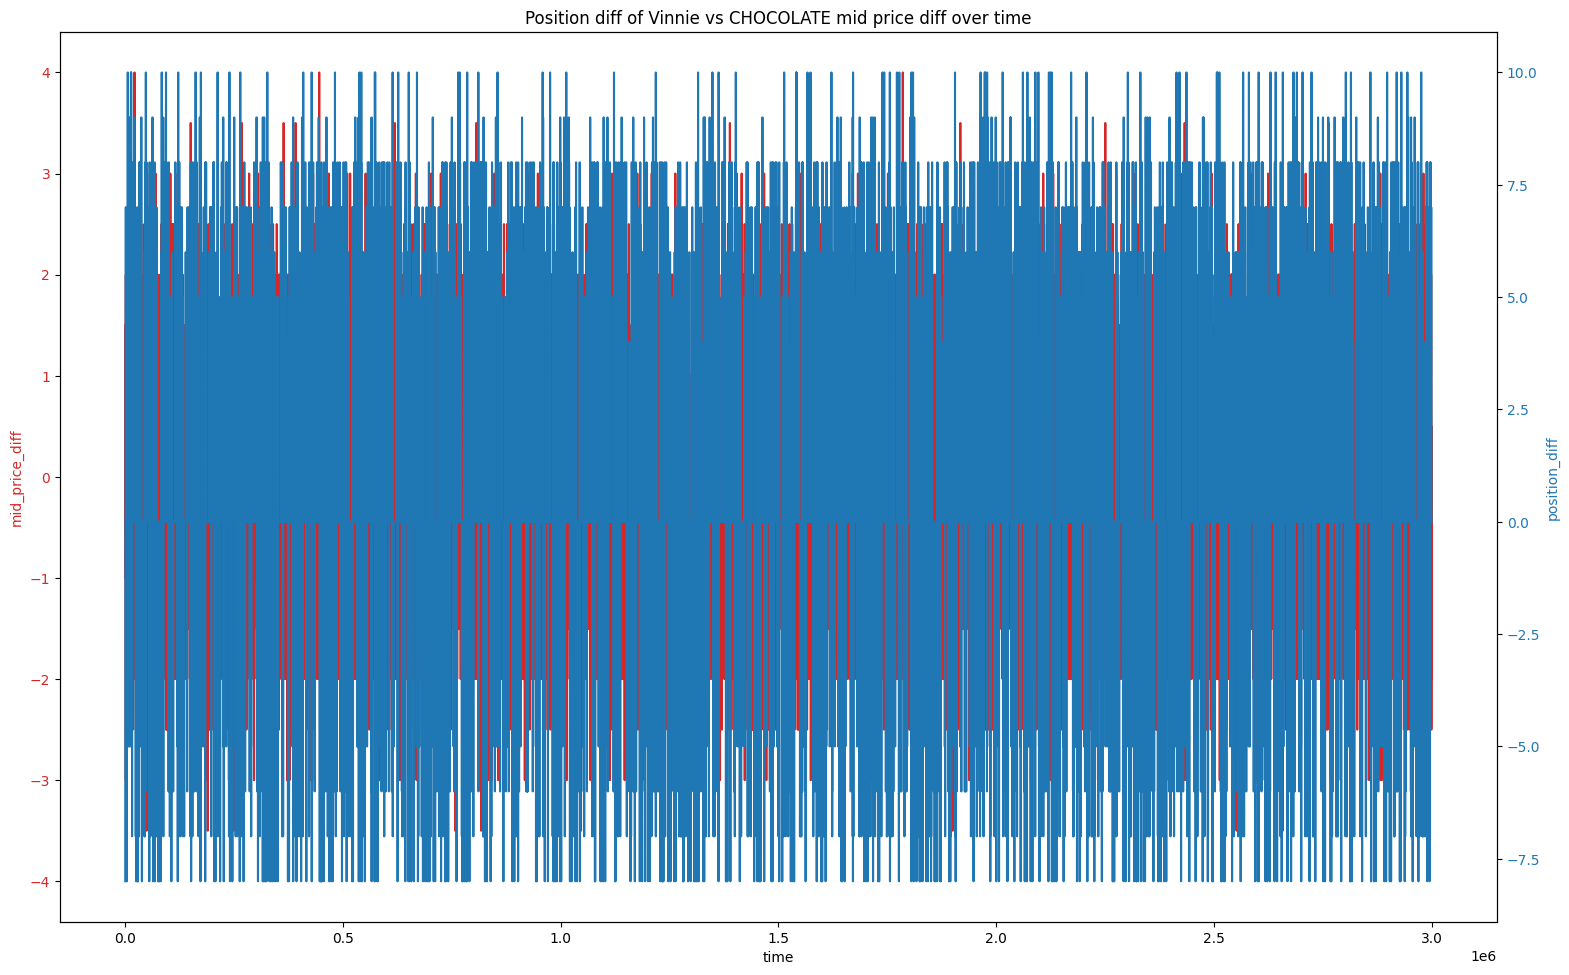

Correlation between mid price diff and position diff: -0.00480710269280685


In [227]:
df_trader['mid_price_diff'] = df_trader['mid_price'].diff()
df_trader['position_diff'] = df_trader['position'].diff()
df_trader['mid_price_diff'] = df_trader['mid_price_diff'].fillna(0)
df_trader['position_diff'] = df_trader['position_diff'].fillna(0)
df_trader['position_diff'] = df_trader['position_diff'].clip(min(df_trader['quantity']), df_trader['quantity'])

#plot position and price over time wtih right y axis for position
#make figure very wide to see the data better
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('mid_price_diff', color=color)
ax1.plot(df_trader['timestamp'], df_trader['mid_price_diff'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('position_diff', color=color)
ax2.plot(df_trader['timestamp'], df_trader['position_diff'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.set_size_inches(18.5, 10.5)
#set title
plt.title(f'Position diff of {TRADER} vs {PRODUCT} mid price diff over time')
plt.show()
print(f'Correlation between mid price diff and position diff: {df_trader["mid_price_diff"].corr(df_trader["position_diff"])}')


Check for signals grouped by snake type and see if they are profitable.

/var/folders/qz/2xz7hqzj4mv4_58tqxfy0z640000gn/T/ipykernel_84092/3297741075.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_vipers['position'] = df_vipers['position'].fillna(method='ffill')


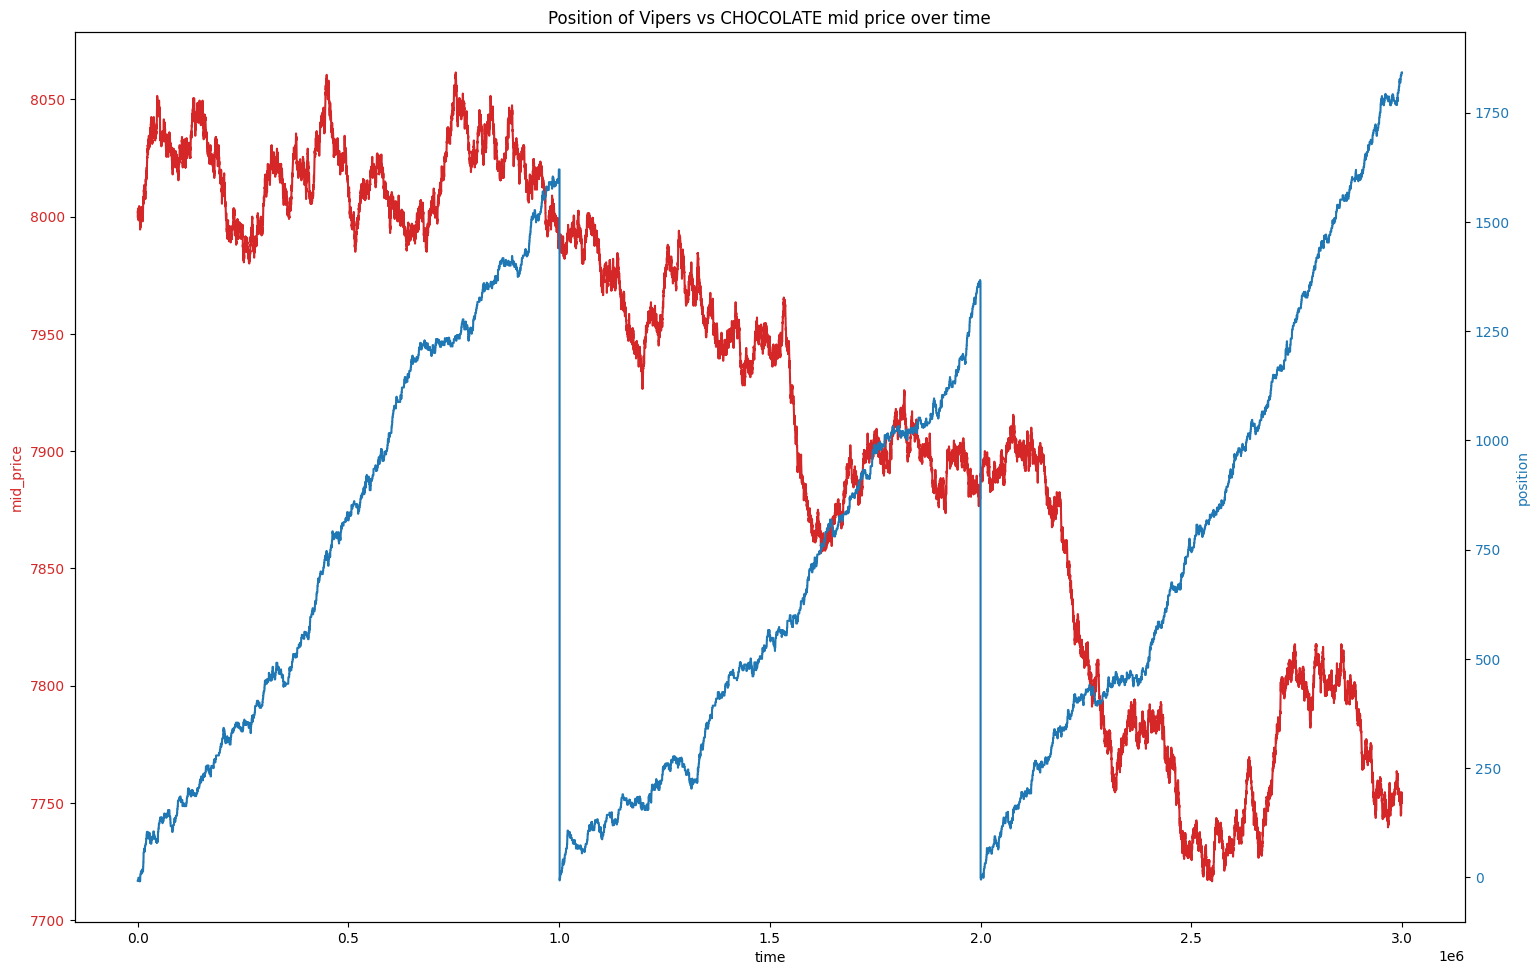

In [228]:
vipers = ['Vinnie', 'Vladimir']

df_vipers = df.query('buyer in @vipers or seller in @vipers').copy()
df_vipers['quantity'] = df_vipers.apply(lambda x: x['quantity'] if x['buyer'] in vipers else -x['quantity'], axis=1)
df_vipers_1 = df_vipers.query('timestamp < 1000000').copy()
df_vipers_1['position'] = df_vipers_1['quantity'].cumsum()
df_vipers_2 = df_vipers.query('timestamp < 2000000 and timestamp >= 1000000').copy()
df_vipers_2['position'] = df_vipers_2['quantity'].cumsum()
df_vipers_3 = df_vipers.query('timestamp < 3000000 and timestamp >= 2000000').copy()
df_vipers_3['position'] = df_vipers_3['quantity'].cumsum()
df_vipers = pd.concat([df_vipers_1, df_vipers_2, df_vipers_3])
df_vipers = df_vipers.merge(prices[['timestamp', 'mid_price']], on='timestamp', how='right')
#fill na values of position with most recent value
df_vipers['position'] = df_vipers['position'].fillna(method='ffill')
df_vipers['position'] = df_vipers['position'].fillna(0)

#plot position and price over time wtih right y axis for position
#make figure very wide to see the data better
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('mid_price', color=color)
ax1.plot(df_vipers['timestamp'], df_vipers['mid_price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('position', color=color)
ax2.plot(df_vipers['timestamp'], df_vipers['position'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.set_size_inches(18.5, 10.5)
#set title
plt.title(f'Position of Vipers vs {PRODUCT} mid price over time')
plt.show()

Check if trader's largest or smallest quantity traded is a signal

Largest trade of CHOCOLATE by Vinnie: 10.0
Smallest trade of CHOCOLATE by Vinnie: -8.0
Value counts of trades of CHOCOLATE by Vinnie: quantity
 7.0     404
 6.0     380
 8.0     372
 5.0     351
-8.0     300
-5.0     285
-7.0     252
-6.0     234
 10.0     92
 4.0      90
 9.0      79
Name: count, dtype: int64


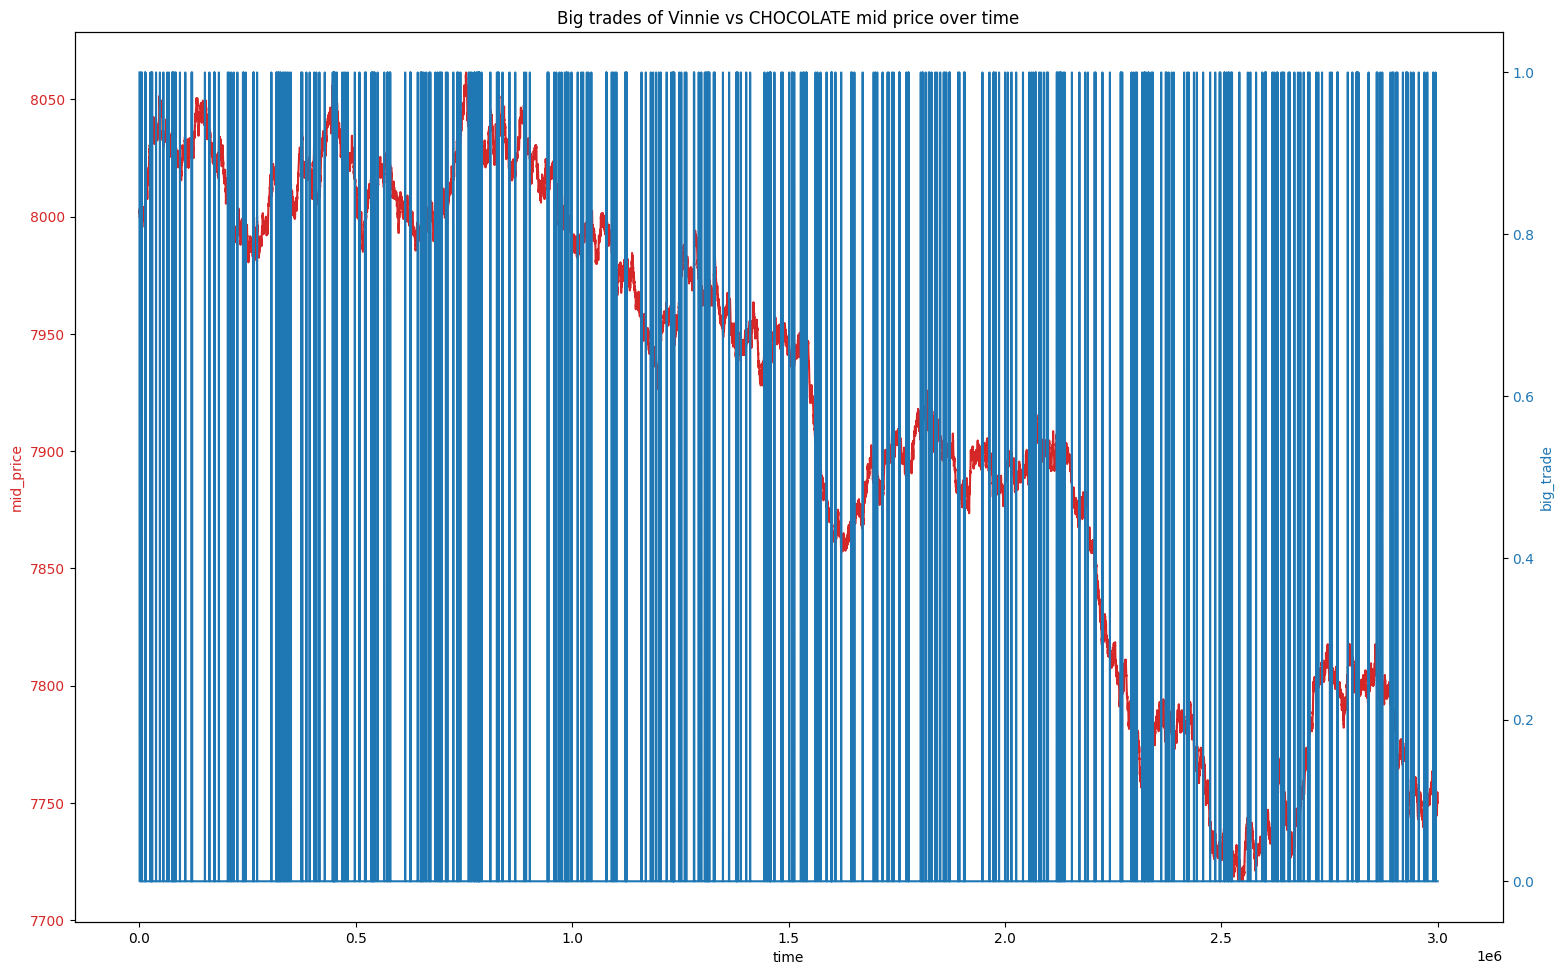

In [229]:
largest_trade = df_trader['quantity'].max()
smallest_trade = df_trader['quantity'].min()
print(f'Largest trade of {PRODUCT} by {TRADER}: {largest_trade}')
print(f'Smallest trade of {PRODUCT} by {TRADER}: {smallest_trade}')
print(f'Value counts of trades of {PRODUCT} by {TRADER}: {df_trader["quantity"].value_counts()}')

df_trader['big_trade'] = (df_trader['quantity'] == largest_trade) | (df_trader['quantity'] == smallest_trade)
df_trader['big_trade'] = df_trader['big_trade'].astype(int)
df_trader['big_trade'] = df_trader['big_trade'].fillna(0)

#plot big_trade and price over time wtih right y axis for big_trade
#make figure very wide to see the data better
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('mid_price', color=color)
ax1.plot(df_trader['timestamp'], df_trader['mid_price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('big_trade', color=color)
ax2.plot(df_trader['timestamp'], df_trader['big_trade'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.set_size_inches(18.5, 10.5)
#set title
plt.title(f'Big trades of {TRADER} vs {PRODUCT} mid price over time')
plt.show()

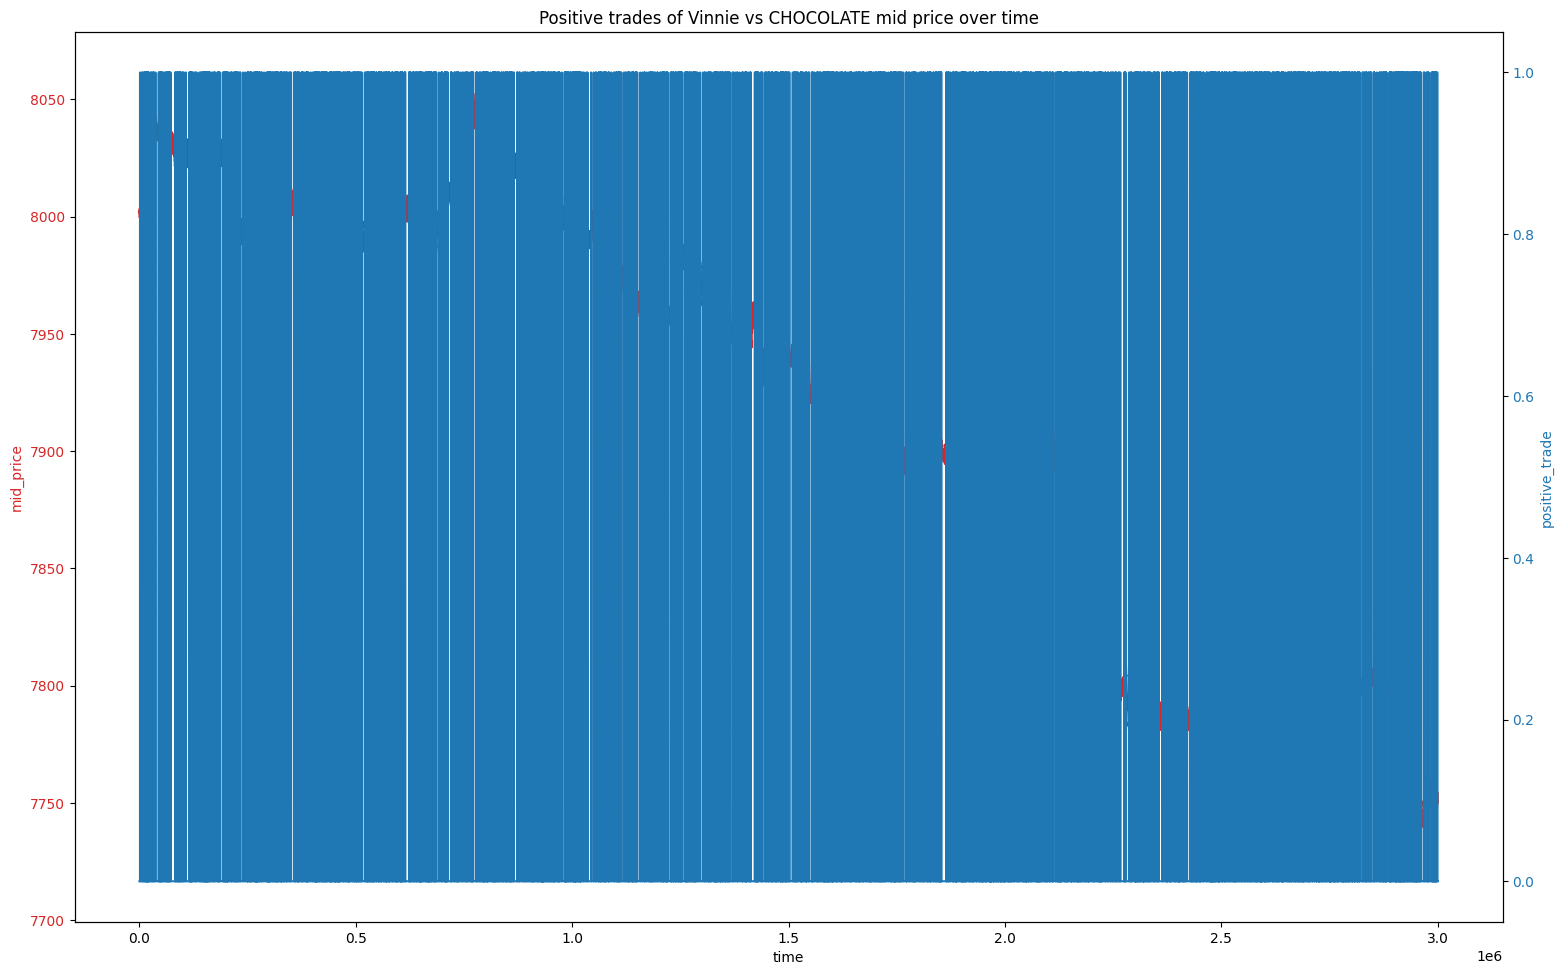

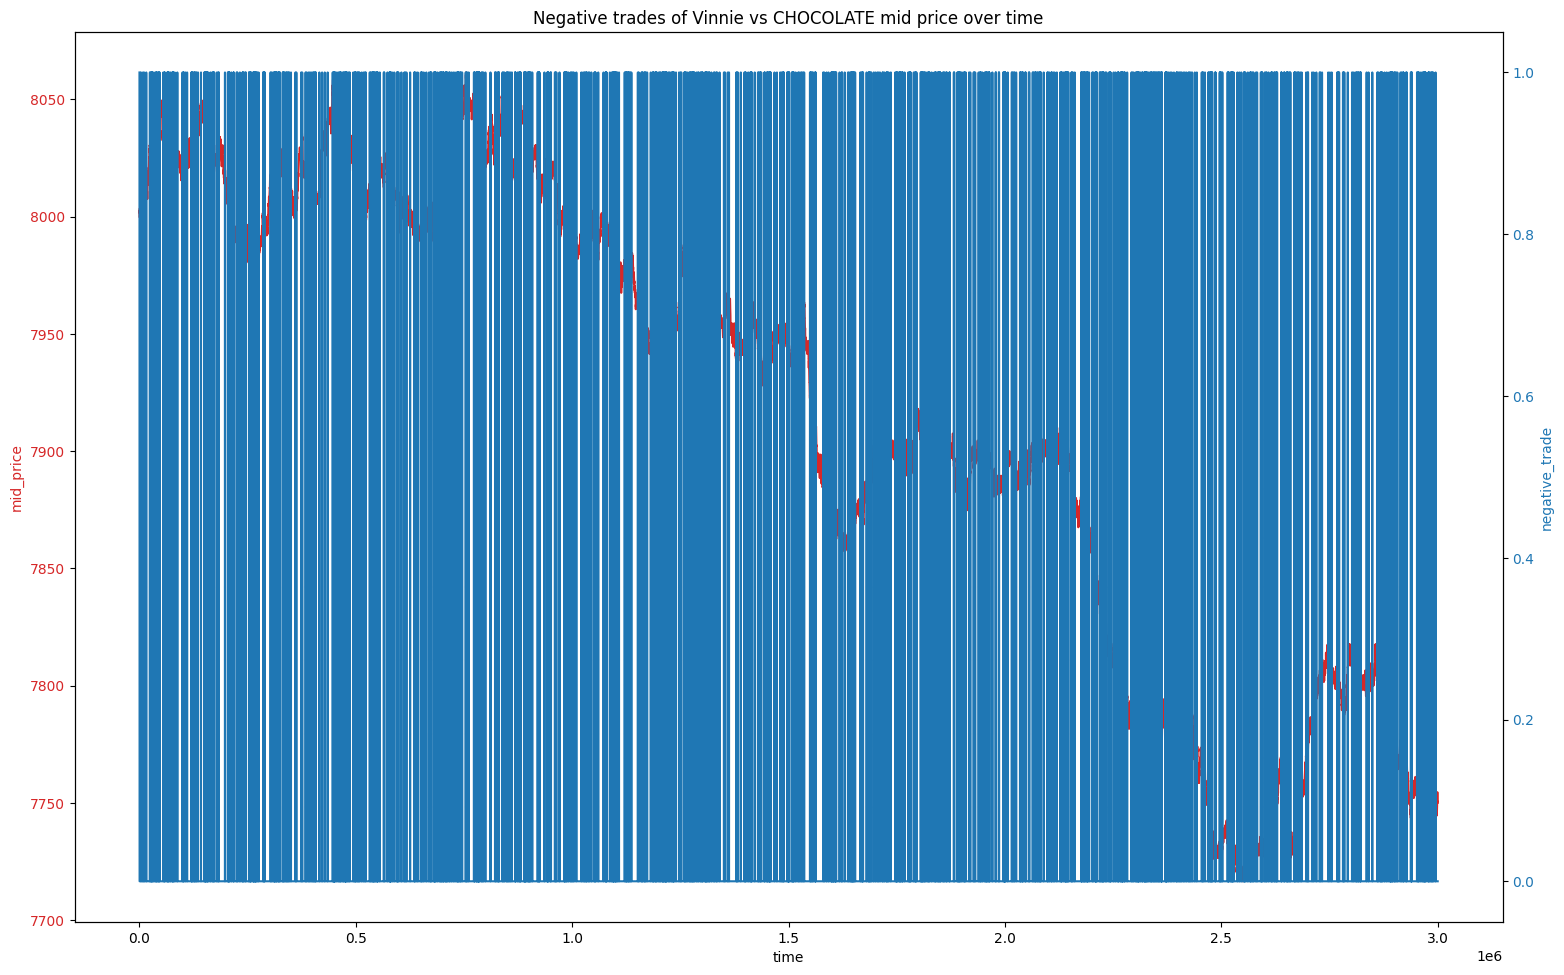

In [230]:
# check what happens after positive trades
df_trader['positive_trade'] = df_trader['quantity'] > 0
df_trader['positive_trade'] = df_trader['positive_trade'].astype(int)
df_trader['positive_trade'] = df_trader['positive_trade'].fillna(0)

#plot positive_trade and price over time wtih right y axis for positive_trade
#make figure very wide to see the data better
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('mid_price', color=color)
ax1.plot(df_trader['timestamp'], df_trader['mid_price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('positive_trade', color=color)
ax2.plot(df_trader['timestamp'], df_trader['positive_trade'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.set_size_inches(18.5, 10.5)
#set title
plt.title(f'Positive trades of {TRADER} vs {PRODUCT} mid price over time')
plt.show()

# check what happens after negative trades
df_trader['negative_trade'] = df_trader['quantity'] < 0
df_trader['negative_trade'] = df_trader['negative_trade'].astype(int)
df_trader['negative_trade'] = df_trader['negative_trade'].fillna(0)

#plot negative_trade and price over time wtih right y axis for negative_trade
#make figure very wide to see the data better
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('mid_price', color=color)
ax1.plot(df_trader['timestamp'], df_trader['mid_price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('negative_trade', color=color)
ax2.plot(df_trader['timestamp'], df_trader['negative_trade'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.set_size_inches(18.5, 10.5)
#set title
plt.title(f'Negative trades of {TRADER} vs {PRODUCT} mid price over time')
plt.show()

/var/folders/qz/2xz7hqzj4mv4_58tqxfy0z640000gn/T/ipykernel_84092/253003753.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_trader_2['position'] = df_trader_2['position'].fillna(method='ffill')


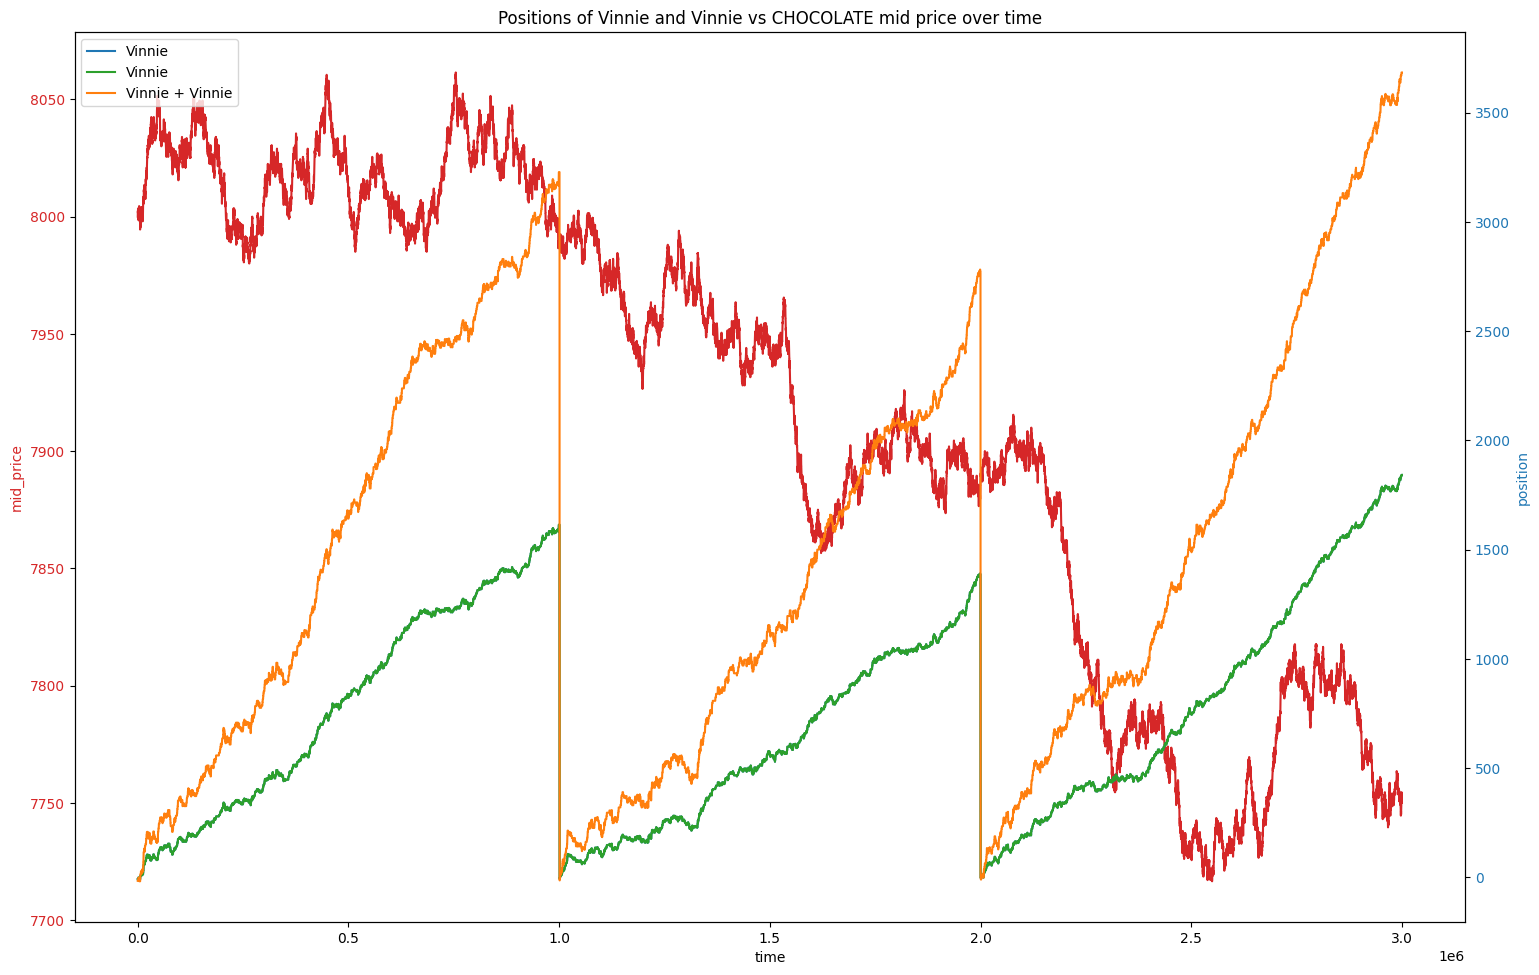

In [231]:
# check linear combination of pairs of traders vs price
TRADER_NAMES = ['Remy', 'Vinnie', 'Vladimir']
TRADER_2 = 'Vinnie'
df_trader_2 = df.query('buyer==@TRADER_2 or seller==@TRADER_2').copy()
df_trader_2['quantity'] = df_trader_2.apply(lambda x: x['quantity'] if x['buyer'] == TRADER_2 else -x['quantity'], axis=1)
df_trader_2_1 = df_trader_2.query('timestamp < 1000000').copy()
df_trader_2_1['position'] = df_trader_2_1['quantity'].cumsum()
df_trader_2_2 = df_trader_2.query('timestamp < 2000000 and timestamp >= 1000000').copy()
df_trader_2_2['position'] = df_trader_2_2['quantity'].cumsum()
df_trader_2_3 = df_trader_2.query('timestamp < 3000000 and timestamp >= 2000000').copy()
df_trader_2_3['position'] = df_trader_2_3['quantity'].cumsum()
df_trader_2 = pd.concat([df_trader_2_1, df_trader_2_2, df_trader_2_3])
df_trader_2 = df_trader_2.merge(prices[['timestamp', 'mid_price']], on='timestamp', how='right')
#fill na values of position with most recent value
df_trader_2['position'] = df_trader_2['position'].fillna(method='ffill')
df_trader_2['position'] = df_trader_2['position'].fillna(0)

df_trader['position_2'] = df_trader_2['position']

#plot positions and price over time wtih right y axis for position
#make figure very wide to see the data better
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('mid_price', color=color)
ax1.plot(df_trader['timestamp'], df_trader['mid_price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('position', color=color)
ax2.plot(df_trader['timestamp'], df_trader['position'], color=color)
ax2.plot(df_trader['timestamp'], df_trader['position_2'], color='tab:green')
ax2.plot(df_trader['timestamp'], df_trader['position'] + df_trader['position_2'], color='tab:orange')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.set_size_inches(18.5, 10.5)
#set title
plt.title(f'Positions of {TRADER} and {TRADER_2} vs {PRODUCT} mid price over time')
plt.legend([TRADER, TRADER_2, f'{TRADER} + {TRADER_2}'])
plt.show()

Number of trades with same buyer and seller: 0


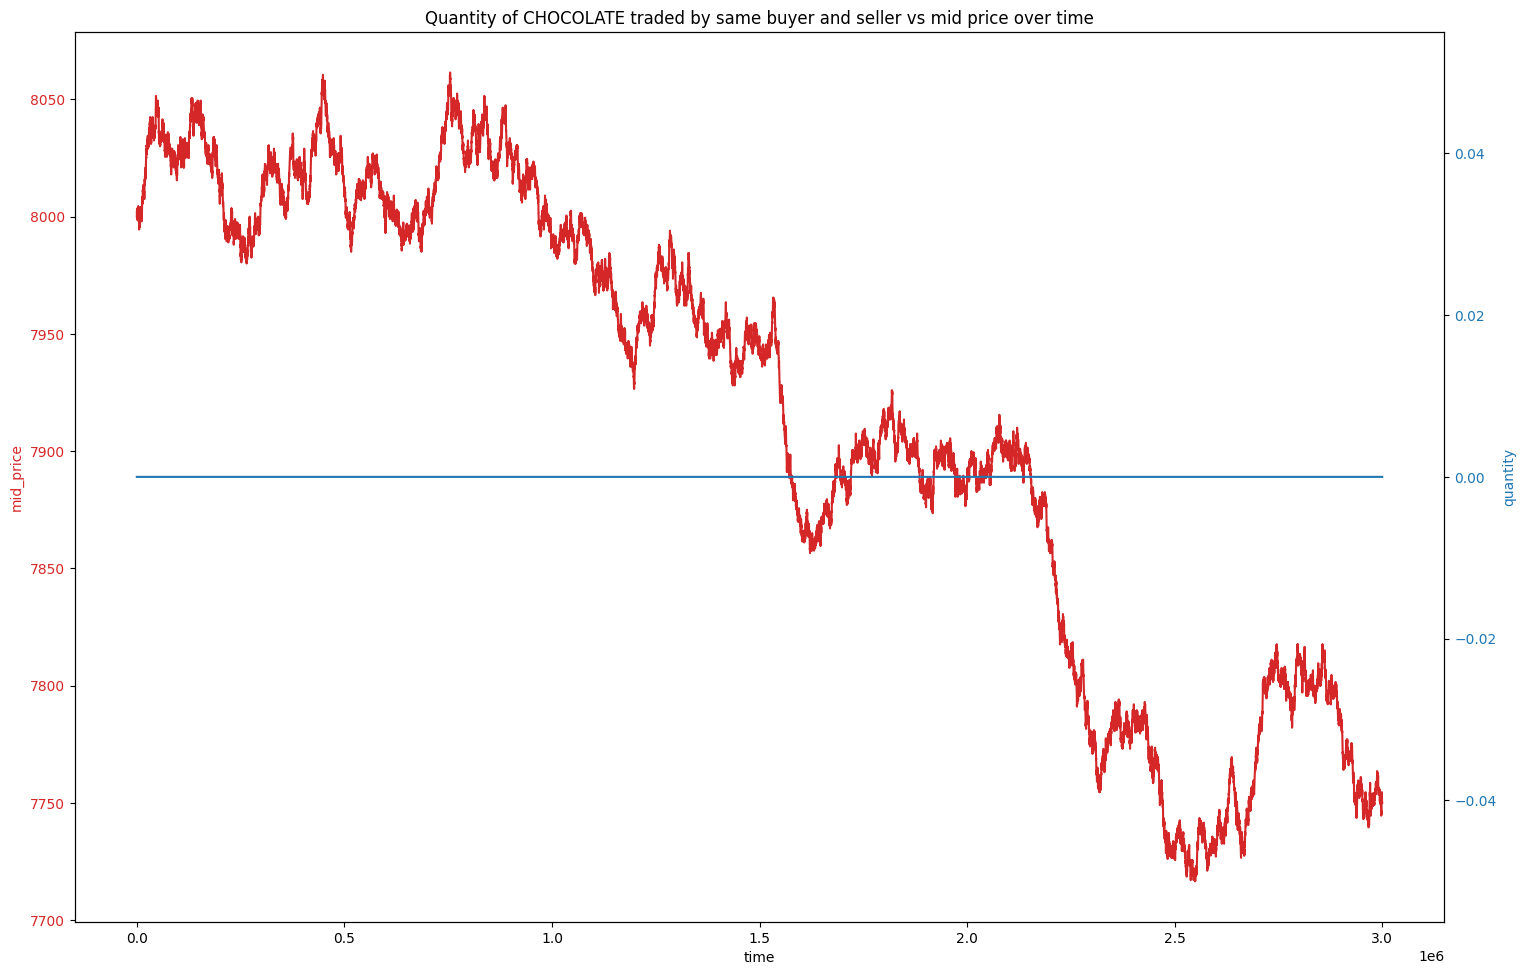

In [232]:
# check for trades with same buyer and seller
df_same = df.query('buyer==seller').copy()
print(f'Number of trades with same buyer and seller: {len(df_same)}')
df_same['quantity'] = df_same['quantity'].abs()
df_same['quantity'] = df_same['quantity'].fillna(0)

df_same = pd.merge(df_same, prices[['timestamp', 'mid_price']], on='timestamp', how='right')
df_same['quantity'] = df_same['quantity'].fillna(0)

#plot quantity and price over time wtih right y axis for quantity
#make figure very wide to see the data better
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('mid_price', color=color)
ax1.plot(df_same['timestamp'], df_same['mid_price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('quantity', color=color)
ax2.plot(df_same['timestamp'], df_same['quantity'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.set_size_inches(18.5, 10.5)
#set title
plt.title(f'Quantity of {PRODUCT} traded by same buyer and seller vs mid price over time')
plt.show()

/var/folders/qz/2xz7hqzj4mv4_58tqxfy0z640000gn/T/ipykernel_84092/3195993227.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_rare['quantity'].fillna(0, inplace=True)
/var/folders/qz/2xz7hqzj4mv4_58tqxfy0z640000gn/T/ipykernel_84092/3195993227.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_rare['position'] = df_rare['position'].fillna(method='ffill')


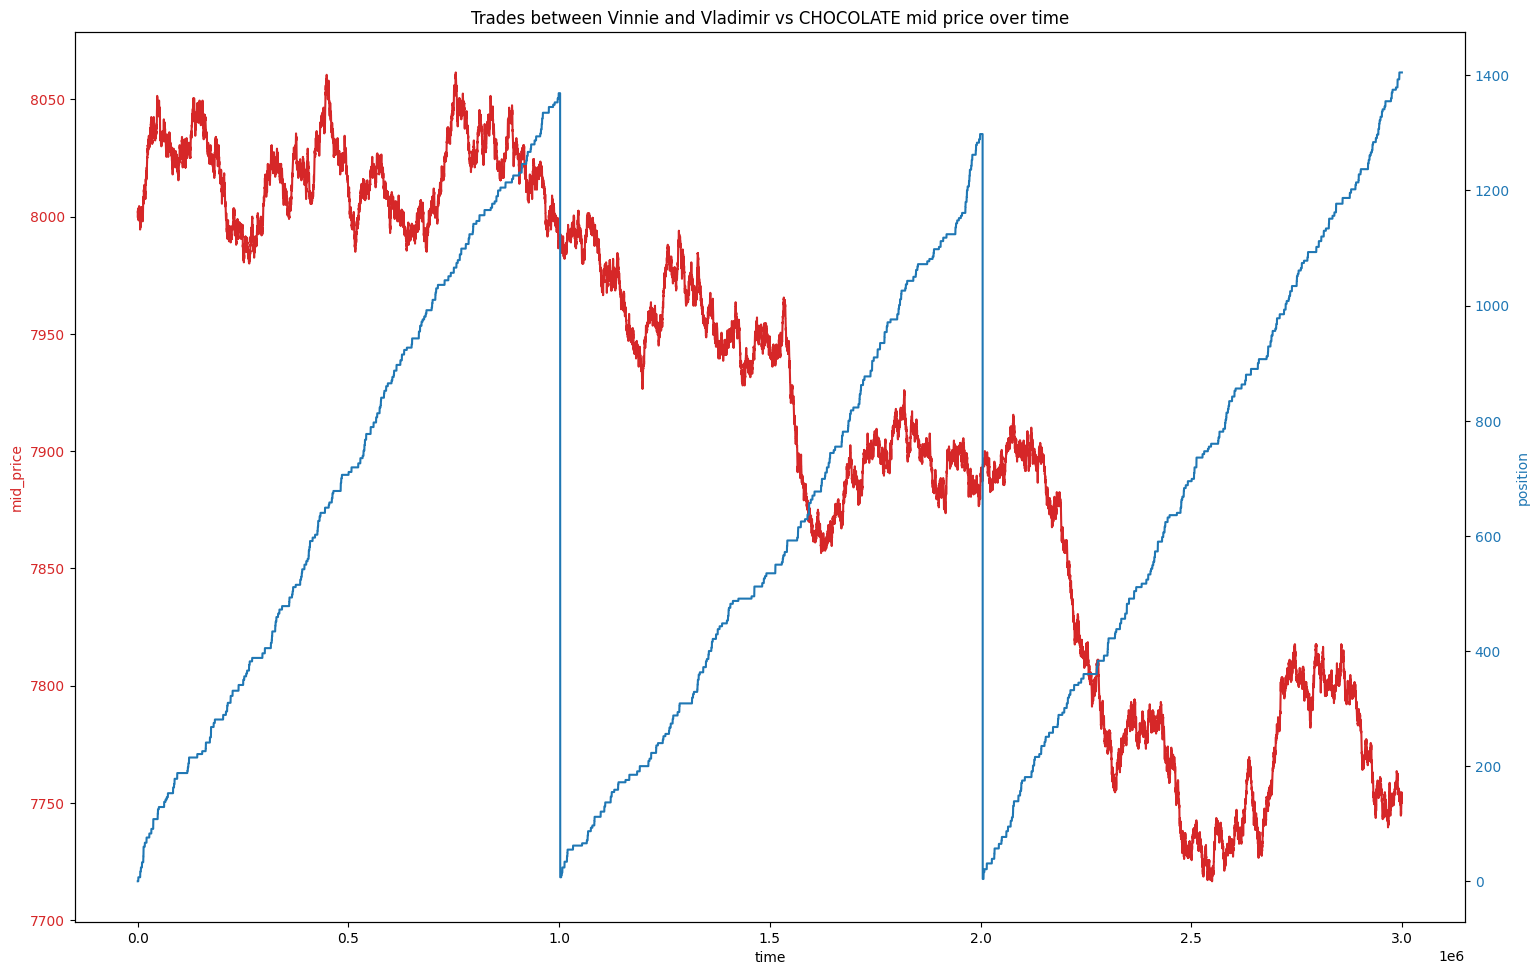

In [233]:
# check if rarely occuring trades are a signal (e.g. here trades between vladimir and Remy)
TRADER_NAMES = ['Remy', 'Vinnie', 'Vladimir']
TRADER2 = 'Vladimir'
df_rare = df.query(f'buyer==@TRADER and seller==@TRADER2 or buyer==@TRADER2 and seller==@TRADER').copy()
df_rare['quantity'] = df_rare.apply(lambda x: x['quantity'] if x['buyer'] == TRADER else -x['quantity'], axis=1)
df_rare_1 = df_rare.query('timestamp < 1000000').copy()
df_rare_1['position'] = df_rare_1['quantity'].cumsum()
df_rare_2 = df_rare.query('timestamp < 2000000 and timestamp >= 1000000').copy()
df_rare_2['position'] = df_rare_2['quantity'].cumsum()
df_rare_3 = df_rare.query('timestamp < 3000000 and timestamp >= 2000000').copy()
df_rare_3['position'] = df_rare_3['quantity'].cumsum()
df_rare = pd.concat([df_rare_1, df_rare_2, df_rare_3])
df_rare = df_rare.merge(prices[['timestamp', 'mid_price']], on='timestamp', how='right')
#fill na values of position with most recent value
df_rare['quantity'].fillna(0, inplace=True)
df_rare['position'] = df_rare['position'].fillna(method='ffill')
df_rare['position'] = df_rare['position'].fillna(0)
#plot quantity and price over time wtih right y axis for quantity
#make figure very wide to see the data better
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('mid_price', color=color)
ax1.plot(df_rare['timestamp'], df_rare['mid_price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('position', color=color)
ax2.plot(df_rare['timestamp'], df_rare['position'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.set_size_inches(18.5, 10.5)
#set title
plt.title(f'Trades between {TRADER} and {TRADER2} vs {PRODUCT} mid price over time')
plt.show()

In [234]:
#try linreg
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

data = df_trader[['mid_price', 'position', 'position_2', 'total_ask_volume', 'total_bid_volume', 'spread', 'mid_price_change_next']].dropna()
X = data[['mid_price', 'position', 'position_2', 'total_ask_volume', 'total_bid_volume', 'spread']]
y = data['mid_price_change_next']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)

print(f'Coefficients of linear regression: {reg.coef_}')
print(f'Intercept of linear regression: {reg.intercept_}')
print(f'Score of linear regression: {reg.score(X_test, y_test)}')


Coefficients of linear regression: [-5.97063948e-05 -2.76782770e-06 -2.76782770e-06  1.42801023e-02
 -1.43697776e-02 -1.68540018e-02]
Intercept of linear regression: 0.501989985739072
Score of linear regression: 0.00013415076396272596
